In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import  train_test_split
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
import pickle
import gzip

os.chdir('../')
from functions.model_wrapper import Tree_Model, rfm_params, xgboost_params, get_y_w_threshold
from functions.dataprep import group_values, replace_DateTime_CycleTime, strong_low_pass_filter

# These are batteries that show anomalies in the measnurements, and are therefore excluded.
excl_filenames = ['2018-04-12_batch8_CH46', '2017-06-30_3_6C-30per_6C_CH15', '2017-06-30_2C-7per_5_5C_CH12',
                  '2018-04-12_batch8_CH46', '2017-06-30_6C-60per_3C_CH48']

In [3]:
with gzip.open('data/filtered_data_frames.pckl', 'rb') as f:
    filtered_data_frames = pickle.load(f)

In [4]:
# get y which is number of cycle it dropped below threshold
threshold = 0.9
X_CC =  filtered_data_frames[0]
X_CC = X_CC[[col for col in X_CC.columns if col not in excl_filenames]]

y_all = get_y_w_threshold(X_CC, threshold)

In [5]:
filtered_data_frames[1].iloc[:1000,:]
y_all.isnull().sum()

np.int64(0)

In [6]:
first100rows_data_frames = [data_frame.iloc[: 100, :] for data_frame in filtered_data_frames]
X_all = pd.concat(first100rows_data_frames, axis = 0).T
X_all = X_all.T[[col for col in X_all.T.columns if col not in excl_filenames]].T
X_all.iloc[:,:]

,2_Charge_Capacity,3_Charge_Capacity,4_Charge_Capacity,5_Charge_Capacity,6_Charge_Capacity,7_Charge_Capacity,8_Charge_Capacity,9_Charge_Capacity,10_Charge_Capacity,11_Charge_Capacity,...,95_CycleTime,96_CycleTime,97_CycleTime,98_CycleTime,99_CycleTime,100_CycleTime,101_CycleTime,102_CycleTime,103_CycleTime,schedule_version
2017-06-30_4_4C-55per_6C_CH19,1.0,0.999469,1.00071,1.001153,1.000947,1.001061,1.001048,1.000631,1.000738,1.000275,...,60.08787,60.09993,60.073277,60.201067,60.051363,59.927752,59.978472,60.083027,60.102322,7.00.08
2018-04-12_batch8_CH38,1.0,1.000355,1.000647,1.000878,1.000875,1.000858,1.000857,1.000757,1.000705,1.000661,...,44.572147,44.595965,44.517665,44.467317,44.607613,44.443833,44.560172,44.453385,44.395298,7.00.13
2018-04-12_batch8_CH10,1.0,1.000607,1.001124,1.001623,1.001856,1.002276,1.002395,1.002756,1.002865,1.002884,...,45.419542,45.475585,45.395157,45.50357,45.584997,45.602177,45.54824,45.590342,45.659787,7.00.13
2017-05-12_7C-30per_3_6C_CH39,1.0,1.000993,1.001488,1.001663,1.001903,1.002134,1.002336,1.001566,1.002752,1.00285,...,51.484705,51.59691,51.481427,51.508457,51.560358,51.482802,51.47205,51.505393,51.495503,7.00.08
2017-06-30_3_6C-80per_3_6C_CH1,1.0,0.999561,1.000024,1.000403,1.000303,0.999825,1.000283,1.000705,0.999735,0.999578,...,50.087073,50.087073,50.087073,49.815145,49.894612,49.894612,49.504907,49.383853,49.366305,7.00.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-12_7C-40per_3_6C_CH41,1.0,1.001021,1.001249,1.001563,1.001953,1.002248,1.002405,1.002483,1.002725,1.00276,...,51.14329,51.143787,51.142278,51.142218,51.158852,51.14201,51.14202,51.141435,51.13668,7.00.08
2018-04-12_batch8_CH21,1.0,1.000793,1.001366,1.001734,1.002036,1.002051,1.002263,1.002459,1.002619,1.002509,...,47.25177,47.300742,47.320268,47.225552,47.243885,47.211918,47.227287,47.310093,47.234753,7.00.13
2018-04-12_batch8_CH35,1.0,1.000817,1.001465,1.001803,1.00217,1.002625,1.002845,1.003059,1.003236,1.003206,...,46.481423,46.433762,46.388213,46.468112,46.503998,46.24005,46.298525,46.364928,46.464727,7.00.13
2017-06-30_4_8C-80per_4_8C_CH8,1.0,1.002038,1.003053,1.003054,1.003826,1.004159,1.003788,1.004376,1.004534,1.004396,...,59.879507,59.86149,59.810603,59.786073,59.821895,59.822375,59.826117,59.869312,59.802775,7.00.08


In [7]:
X_all.fillna(0, inplace = True)

In [8]:
X_all["schedule_version"] = X_all["schedule_version"] == '7.00.08'

In [9]:
X_all = X_all.astype('float')
X_all['schedule_version'] = X_all['schedule_version'].astype('bool')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    train_size=0.8, test_size=0.2, 
                                                    random_state=120)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    train_size=0.9, test_size=0.1, 
                                                    random_state=
                                                  120)
xgboost_params['eval_set'] = [(X_train, y_train), (X_val, y_val)]

In [35]:
xgboost_params["n_jobs"] = 7
xgboost_params['learning_rate'] = 1e-5
xgboost_params["max_depth"]= 6
xgboost_params["verbose"] = 1000
xgboost_params["early_stopping_rounds"] = 1000

In [36]:
X_all.shape

(132, 401)

[21:09:17] ======== Monitor (0): HostSketchContainer ========
[21:09:17] AllReduce: 0.001464s, 1 calls @ 1464us

[21:09:17] MakeCuts: 0.001768s, 1 calls @ 1768us

[21:09:17] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70666	validation_1-rmse:218.51860


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-e_IOXrlx-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:09:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.11031	validation_1-rmse:216.81935
[2000]	validation_0-rmse:326.54533	validation_1-rmse:215.15969
[3000]	validation_0-rmse:323.98986	validation_1-rmse:213.49857
[4000]	validation_0-rmse:321.46310	validation_1-rmse:211.88605
[5000]	validation_0-rmse:318.95307	validation_1-rmse:210.27485
[6000]	validation_0-rmse:316.47044	validation_1-rmse:208.70912
[7000]	validation_0-rmse:314.00930	validation_1-rmse:207.13880
[8000]	validation_0-rmse:311.56717	validation_1-rmse:205.59581
[9000]	validation_0-rmse:309.14537	validation_1-rmse:204.07326
[10000]	validation_0-rmse:306.76685	validation_1-rmse:202.57376
[11000]	validation_0-rmse:304.41508	validation_1-rmse:201.10209
[12000]	validation_0-rmse:302.07864	validation_1-rmse:199.64092
[13000]	validation_0-rmse:299.77201	validation_1-rmse:198.22069
[14000]	validation_0-rmse:297.47632	validation_1-rmse:196.79970
[15000]	validation_0-rmse:295.20528	validation_1-rmse:195.41079
[16000]	validation_0-rmse:292.94621	validation_1-

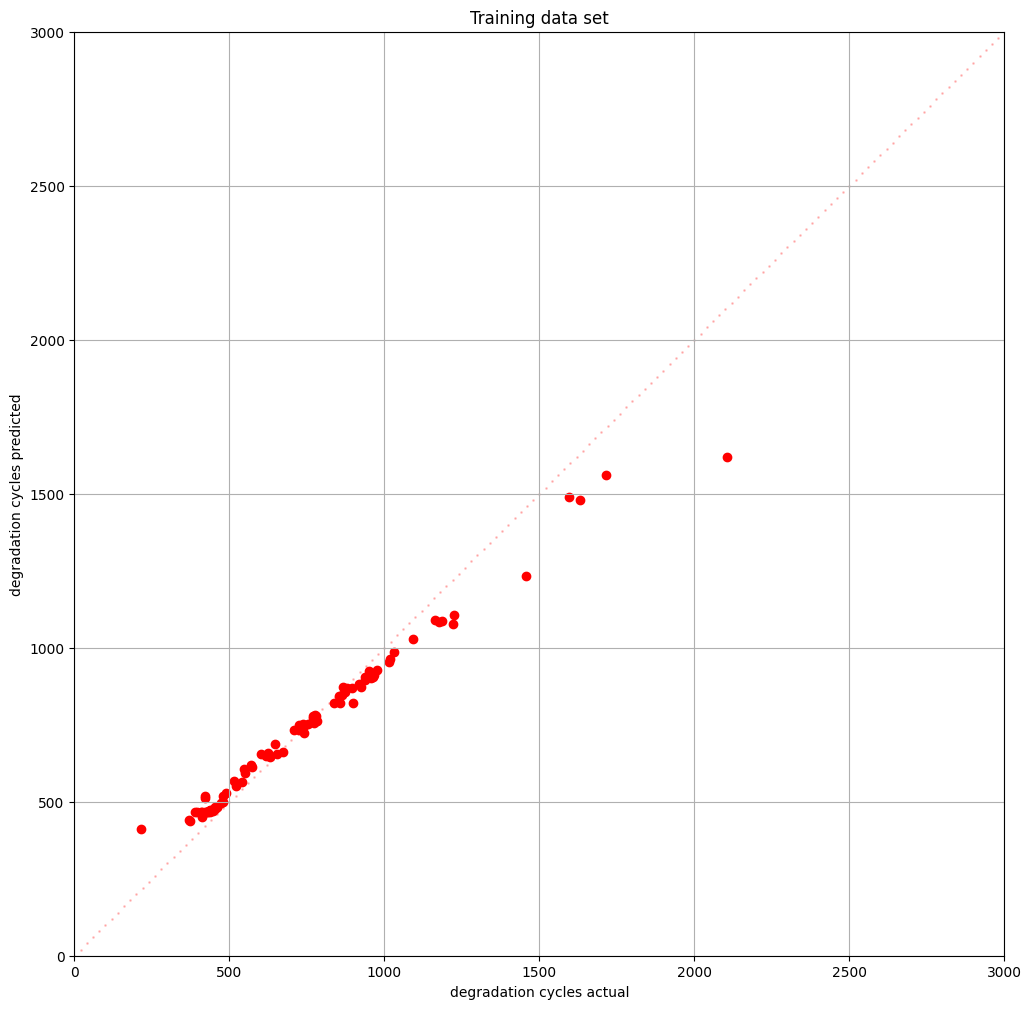

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.5, colsample_bytree=0.5,
             device=None, early_stopping_rounds=1000, enable_categorical=False,
             eval_metric='rmse',
             eval_set=[(                               2_Charge_Capacity  3_Charge_Capacity  \
2017-05-12_5_4C-50per_3C_CH14                1.0           1.001425   
2017-05-12_7C-40per_3C_CH38                  1.0           1.000948   
2018-04-12_batch8_CH4...
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=1e-05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=1000000, n_jobs=7, num_parallel_tree=None, ...)

In [37]:
#Depth = 6
gbm = Tree_Model(Model = XGBRegressor,
                 params = xgboost_params,
                 cycle_max = 3000
                 )
gbm.fit(X_train, y_train)

MdAPE is 16.603737403936638%
R2: 0.478, RMSE: 234.110, MAE: 172.838
Plotting scatter plot...


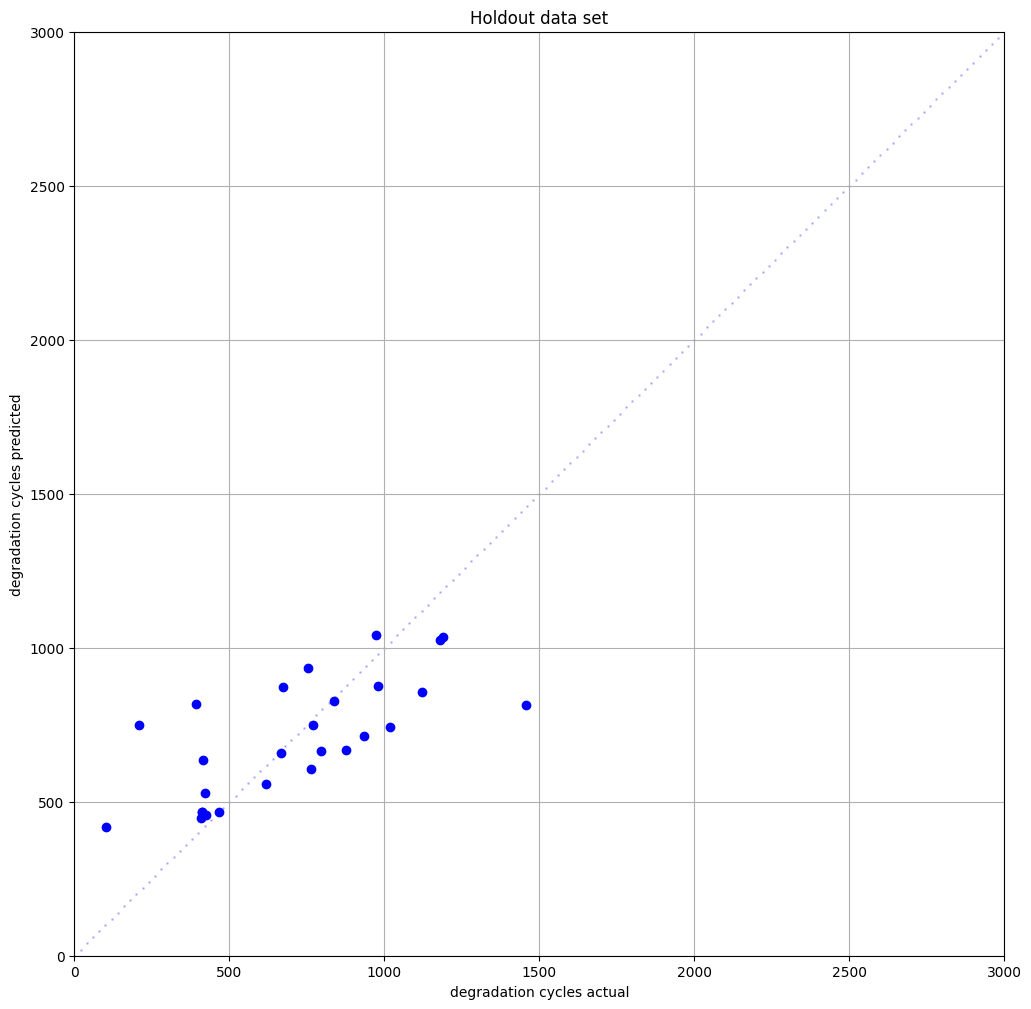

array([ 465.61487,  750.1654 , 1041.7507 , 1026.5685 ,  664.6682 ,
        457.11606,  934.7901 ,  874.09186,  419.4657 ,  818.27893,
        747.65076,  467.49142,  855.9978 ,  558.06635,  465.6261 ,
        814.4824 ,  874.61224,  666.6259 ,  447.28912,  604.75867,
        635.1238 ,  741.0342 ,  527.1611 , 1033.3151 ,  827.3416 ,
        712.06995,  658.90155], dtype=float32)

In [38]:
gbm.predict(X_test, y_test)

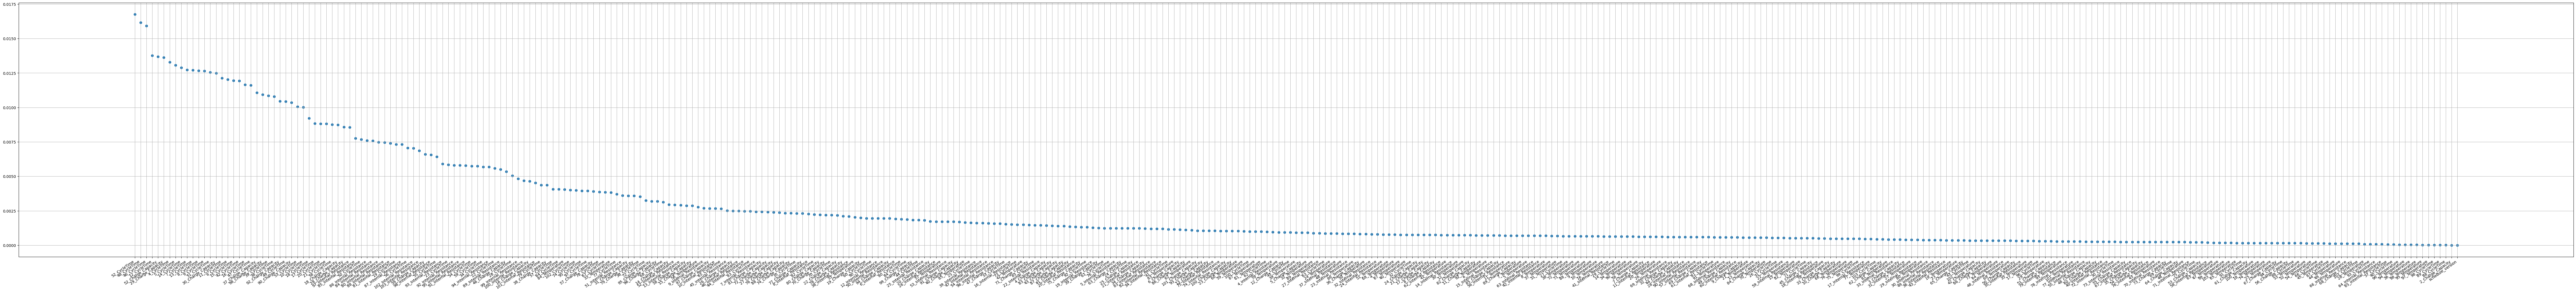

In [39]:
data_points =[x[0] for x in gbm.feature_imp]
importances =[x[1] for x in gbm.feature_imp]
plt.figure(figsize=(120,12))
plt.scatter(data_points, importances)
plt.xticks(rotation = 35, horizontalalignment = 'right')
plt.grid()
plt.savefig('figures/feature_imp.png')
plt.show()


In [40]:
 [(x[0], float(x[1])) for x in gbm.feature_imp]

[('52_CycleTime', 0.016760362312197685),
 ('48_CycleTime', 0.016157476231455803),
 ('46_CycleTime', 0.015911977738142014),
 ('12_CycleTime', 0.013764255680143833),
 ('52_Charge_Capacity', 0.013681360520422459),
 ('29_Charge_Capacity', 0.013622231781482697),
 ('4_CycleTime', 0.013285830616950989),
 ('5_CycleTime', 0.013070435263216496),
 ('14_CycleTime', 0.012890024110674858),
 ('7_CycleTime', 0.012737412936985493),
 ('13_CycleTime', 0.01271794829517603),
 ('8_CycleTime', 0.012671131640672684),
 ('9_CycleTime', 0.012655558995902538),
 ('51_CycleTime', 0.012542922049760818),
 ('30_Charge_Capacity', 0.012487947940826416),
 ('11_CycleTime', 0.012135816738009453),
 ('6_CycleTime', 0.012040072120726109),
 ('15_CycleTime', 0.011950710788369179),
 ('42_CycleTime', 0.011933191679418087),
 ('16_CycleTime', 0.011650032363831997),
 ('47_CycleTime', 0.011616255156695843),
 ('37_Charge_Capacity', 0.01108323410153389),
 ('98_Charge_Capacity', 0.010938790626823902),
 ('39_CycleTime', 0.010856155306100

In [41]:
importances_sums = {}
for feature_imp in gbm.feature_imp:
    category = feature_imp[0].split('_')[-1]
    if category in importances_sums.keys():
        importances_sums[category] += float(feature_imp[1])
    else:
        importances_sums[category] = float(feature_imp[1])
import_sums = [(key, importances_sums[key]) for key in importances_sums.keys()]

import_sums = sorted(import_sums, key=lambda x: x[1], reverse = True)
str([(x[0], float(np.round(x[1], 5))) for x in import_sums])

"[('CycleTime', 0.49015), ('Capacity', 0.23148), ('Resistance', 0.21346), ('Temperature', 0.06491), ('version', 0.0)]"

In [42]:
gbm_model = gbm.model

In [43]:
errors = gbm_model.evals_result_

In [44]:
errors.keys()

dict_keys(['validation_0', 'validation_1'])

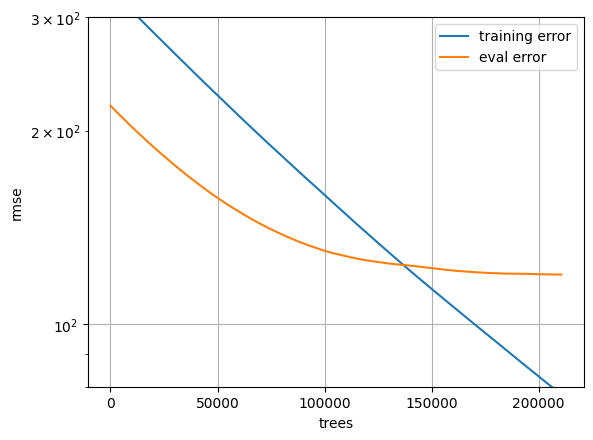

In [45]:
plt.plot(errors['validation_0']['rmse'], label = "training error")
plt.plot(errors['validation_1']['rmse'], label = "eval error")
plt.ylim(80,300)
plt.xlabel("trees")
plt.semilogy(minors = True)
plt.grid()
plt.ylabel("rmse")
plt.legend()
plt.show()

In [46]:
gbm.feature_imp

[('52_CycleTime', np.float32(0.016760362)),
 ('48_CycleTime', np.float32(0.016157476)),
 ('46_CycleTime', np.float32(0.015911978)),
 ('12_CycleTime', np.float32(0.013764256)),
 ('52_Charge_Capacity', np.float32(0.0136813605)),
 ('29_Charge_Capacity', np.float32(0.013622232)),
 ('4_CycleTime', np.float32(0.013285831)),
 ('5_CycleTime', np.float32(0.013070435)),
 ('14_CycleTime', np.float32(0.012890024)),
 ('7_CycleTime', np.float32(0.012737413)),
 ('13_CycleTime', np.float32(0.012717948)),
 ('8_CycleTime', np.float32(0.012671132)),
 ('9_CycleTime', np.float32(0.012655559)),
 ('51_CycleTime', np.float32(0.012542922)),
 ('30_Charge_Capacity', np.float32(0.012487948)),
 ('11_CycleTime', np.float32(0.012135817)),
 ('6_CycleTime', np.float32(0.012040072)),
 ('15_CycleTime', np.float32(0.011950711)),
 ('42_CycleTime', np.float32(0.011933192)),
 ('16_CycleTime', np.float32(0.011650032)),
 ('47_CycleTime', np.float32(0.011616255)),
 ('37_Charge_Capacity', np.float32(0.011083234)),
 ('98_Charge_

In [47]:
category

'version'

In [48]:
importances_sums = {}
for feature_imp in gbm.feature_imp:
    category = feature_imp[0].split('_')[-1]
    if category in importances_sums.keys():
        importances_sums[category] += float(feature_imp[-1])
    else:
        importances_sums[category] = float(feature_imp[-1])

In [49]:
importances_sums

{'CycleTime': 0.4901482659324756,
 'Capacity': 0.23147856200375827,
 'Resistance': 0.21345982000639196,
 'Temperature': 0.06491332758196222,
 'version': 0.0}

In [50]:
xgboost_params["n_jobs"] = 7
xgboost_params['learning_rate'] = 1e-6
xgboost_params["max_depth"]= 8
xgboost_params["verbose"] = 5000
xgboost_params["early_stopping_rounds"] = 3000


[21:23:56] ======== Monitor (0): HostSketchContainer ========
[21:23:56] AllReduce: 0.000239s, 1 calls @ 239us

[21:23:56] MakeCuts: 0.000388s, 1 calls @ 388us

[21:23:56] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70906	validation_1-rmse:218.52004


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-e_IOXrlx-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5000]	validation_0-rmse:330.39510	validation_1-rmse:217.63799
[10000]	validation_0-rmse:329.08248	validation_1-rmse:216.75569
[15000]	validation_0-rmse:327.77165	validation_1-rmse:215.87510
[20000]	validation_0-rmse:326.46206	validation_1-rmse:214.99699
[25000]	validation_0-rmse:325.15262	validation_1-rmse:214.11769
[30000]	validation_0-rmse:323.84442	validation_1-rmse:213.24207
[35000]	validation_0-rmse:322.53737	validation_1-rmse:212.36544
[40000]	validation_0-rmse:321.23094	validation_1-rmse:211.49016
[45000]	validation_0-rmse:319.92481	validation_1-rmse:210.61501
[50000]	validation_0-rmse:318.62133	validation_1-rmse:209.74854
[55000]	validation_0-rmse:317.32367	validation_1-rmse:208.87901
[60000]	validation_0-rmse:316.03428	validation_1-rmse:208.02258
[65000]	validation_0-rmse:314.75311	validation_1-rmse:207.16918
[70000]	validation_0-rmse:313.48729	validation_1-rmse:206.31475
[75000]	validation_0-rmse:312.22365	validation_1-rmse:205.46373
[80000]	validation_0-rmse:310.96695	valid

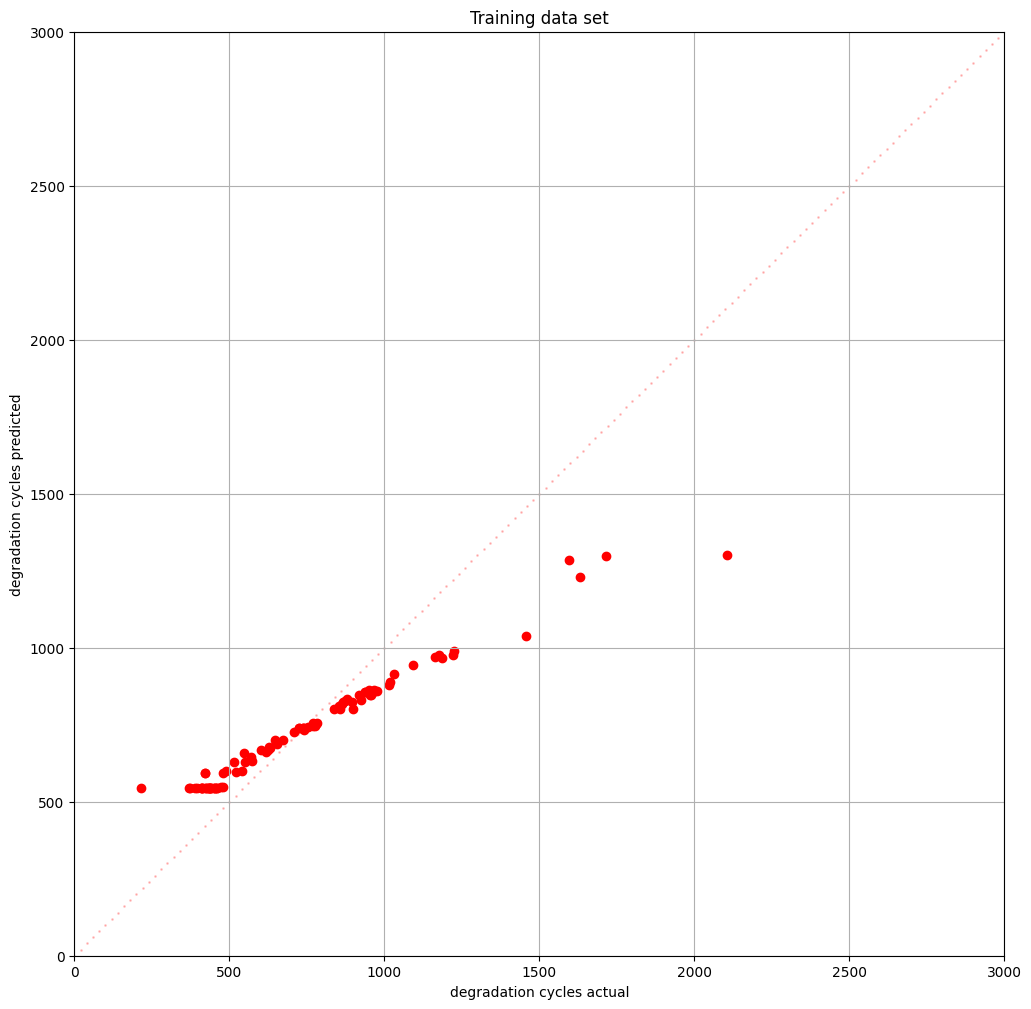

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.5, colsample_bytree=0.5,
             device=None, early_stopping_rounds=3000, enable_categorical=False,
             eval_metric='rmse',
             eval_set=[(                               2_Charge_Capacity  3_Charge_Capacity  \
2017-05-12_5_4C-50per_3C_CH14                1.0           1.001425   
2017-05-12_7C-40per_3C_CH38                  1.0           1.000948   
2018-04-12_batch8_CH4...
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=1e-06, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=1000000, n_jobs=7, num_parallel_tree=None, ...)

In [51]:
#Depth = 8
gbm = Tree_Model(Model = XGBRegressor,
                 params = xgboost_params,
                 cycle_max = 3000
                 )
gbm.fit(X_train, y_train)

MdAPE is 23.197637409924372%
R2: 0.360, RMSE: 259.173, MAE: 199.953
Plotting scatter plot...


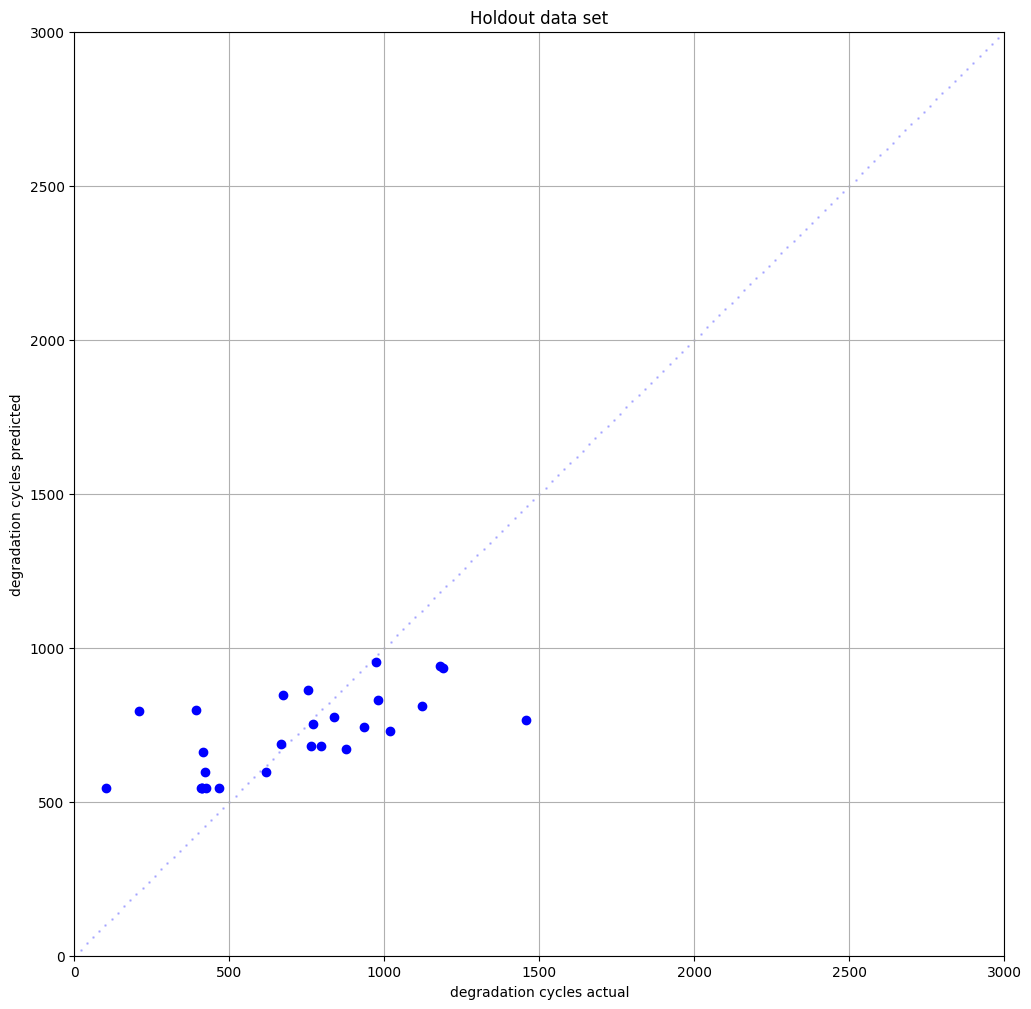

array([544.07837, 793.6964 , 953.75995, 941.9258 , 681.53986, 544.07837,
       861.959  , 847.99255, 544.07837, 797.8735 , 751.1987 , 544.07837,
       810.29205, 595.8284 , 544.07837, 765.3669 , 830.68365, 672.7887 ,
       544.07837, 680.72345, 660.47253, 728.24274, 595.008  , 933.153  ,
       776.6271 , 744.00964, 687.39435], dtype=float32)

In [52]:
gbm.predict(X_test, y_test)

In [53]:
xgboost_params["n_jobs"] = 7
xgboost_params['learning_rate'] = 1e-6
xgboost_params["max_depth"]= 10
xgboost_params["verbose"] = 5000
xgboost_params["early_stopping_rounds"] = 3000


In [ ]:
#Depth = 10
gbm = Tree_Model(Model = XGBRegressor,
                 params = xgboost_params,
                 cycle_max = 3000
                 )
gbm.fit(X_train, y_train)

[22:44:00] ======== Monitor (0): HostSketchContainer ========
[22:44:00] AllReduce: 0.000219s, 1 calls @ 219us

[22:44:00] MakeCuts: 0.000633s, 1 calls @ 633us

[22:44:00] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70906	validation_1-rmse:218.52004


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-e_IOXrlx-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:44:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5000]	validation_0-rmse:330.39488	validation_1-rmse:217.63699
[10000]	validation_0-rmse:329.08224	validation_1-rmse:216.75404
[15000]	validation_0-rmse:327.77085	validation_1-rmse:215.87148
[20000]	validation_0-rmse:326.46072	validation_1-rmse:214.99435
[25000]	validation_0-rmse:325.15081	validation_1-rmse:214.11457
[30000]	validation_0-rmse:323.84197	validation_1-rmse:213.23795
[35000]	validation_0-rmse:322.53413	validation_1-rmse:212.36289
[40000]	validation_0-rmse:321.22717	validation_1-rmse:211.48803
[45000]	validation_0-rmse:319.92029	validation_1-rmse:210.61679
[50000]	validation_0-rmse:318.61690	validation_1-rmse:209.74969
[55000]	validation_0-rmse:317.31911	validation_1-rmse:208.88213
[60000]	validation_0-rmse:316.02964	validation_1-rmse:208.02866
[65000]	validation_0-rmse:314.74769	validation_1-rmse:207.17528
[70000]	validation_0-rmse:313.48238	validation_1-rmse:206.32166
[75000]	validation_0-rmse:312.21816	validation_1-rmse:205.47097
[80000]	validation_0-rmse:310.95889	valid

In [ ]:
gbm.predict(X_test, y_test)

In [ ]:
xgboost_params["n_jobs"] = 7
xgboost_params['learning_rate'] = 1e-6
xgboost_params["max_depth"]= 4
xgboost_params["verbose"] = 5000
xgboost_params["early_stopping_rounds"] = 3000

In [ ]:
#Depth = 4
gbm = Tree_Model(Model = XGBRegressor,
                 params = xgboost_params,
                 cycle_max = 3000
                 )
gbm.fit(X_train, y_train)

In [ ]:
gbm.predict(X_test, y_test)

In [ ]:
gbm.predict(X_test, y_test)

In [ ]:
gbm.feature_imp

In [ ]:
X_y = pd.concat([X_all.iloc[:,-22:], y_all], axis = 1)
X_y

In [ ]:
corr_X_y = X_y.corr()

In [ ]:
import seaborn as sns
%matplotlib inline

# plot the heatmap
sns.heatmap(corr_X_y, cmap='RdBu')

In [ ]:
corr_X_y.iloc[-1,:]